In [1]:
!pip install -q kaggle tensorflow opencv-python scikit-learn numpy matplotlib pandas scipy


In [2]:
# Upload kaggle.json
from google.colab import files
files.upload()   # upload kaggle.json


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"prasadnikhil176","key":"5e572ab8a9f354a3cc8939025de364b1"}'}

In [3]:
# Configure Kaggle
import os

os.makedirs("/root/.kaggle", exist_ok=True)
!cp kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json


In [4]:
# Download dataset
!kaggle datasets download -d mohamedgobara/multi-class-knee-osteoporosis-x-ray-dataset


Dataset URL: https://www.kaggle.com/datasets/mohamedgobara/multi-class-knee-osteoporosis-x-ray-dataset
License(s): apache-2.0
 98% 1.15G/1.17G [00:08<00:00, 254MB/s]
100% 1.17G/1.17G [00:08<00:00, 148MB/s]


In [5]:
# Unzip automatically
if not os.path.exists("/content/knee_dataset"):
    os.makedirs("/content/knee_dataset", exist_ok=True)
    !unzip -q multi-class-knee-osteoporosis-x-ray-dataset.zip -d /content/knee_dataset


In [6]:
# Dataset path handling
DATASET_PATH = "/content/knee_dataset"

subdirs = [d for d in os.listdir(DATASET_PATH)
           if os.path.isdir(os.path.join(DATASET_PATH, d))]

if len(subdirs) == 1:
    DATASET_PATH = os.path.join(DATASET_PATH, subdirs[0])

print("Final DATASET_PATH:", DATASET_PATH)
print("Classes:", os.listdir(DATASET_PATH))


Final DATASET_PATH: /content/knee_dataset/OS Collected Data
Classes: ['Normal', 'Osteoporosis', 'Osteopenia']


In [8]:
import cv2, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.svm import SVC

import tensorflow as tf
from tensorflow.keras.applications import ResNet50, InceptionV3
from tensorflow.keras.applications.resnet50 import preprocess_input as res_pre
from tensorflow.keras.applications.inception_v3 import preprocess_input as inc_pre

SEED = 42
IMG_SIZE = 160   # 🔴 reduced
BATCH = 16       # 🔴 batch-wise
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)


In [9]:
def load_images(path):
    images, labels = [], []
    for label in sorted(os.listdir(path)):
        folder = os.path.join(path, label)
        for img in os.listdir(folder):
            img_path = os.path.join(folder, img)
            image = cv2.imread(img_path)
            image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
            images.append(image)
            labels.append(label)
    return np.array(images), np.array(labels)

X, y = load_images(DATASET_PATH)
y = LabelEncoder().fit_transform(y)

Xtr, Xte, ytr, yte = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=SEED
)


In [10]:
def extract_features(model, preprocess, data):
    feats = []
    for i in range(0, len(data), BATCH):
        batch = preprocess(data[i:i+BATCH].astype(np.float32))
        feats.append(model.predict(batch, verbose=0))
    return np.vstack(feats)

resnet = ResNet50(weights="imagenet", include_top=False, pooling="avg",
                  input_shape=(IMG_SIZE, IMG_SIZE, 3))
inception = InceptionV3(weights="imagenet", include_top=False, pooling="avg",
                        input_shape=(IMG_SIZE, IMG_SIZE, 3))

F_res_tr = extract_features(resnet, res_pre, Xtr)
F_res_te = extract_features(resnet, res_pre, Xte)

F_inc_tr = extract_features(inception, inc_pre, Xtr)
F_inc_te = extract_features(inception, inc_pre, Xte)

# Multi-pretrained fusion
F_tr = np.concatenate([F_res_tr, F_inc_tr], axis=1)
F_te = np.concatenate([F_res_te, F_inc_te], axis=1)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [11]:
def fitness(mask, X, y):
    if mask.sum() == 0:
        return 1
    Xs = X[:, mask==1]
    clf = SVC(kernel="linear")
    clf.fit(Xs, y)
    return 1 - accuracy_score(y, clf.predict(Xs))

def bRPO(X, y, pop=10, iters=10):  # 🔴 reduced
    dim = X.shape[1]
    popu = np.random.randint(0,2,(pop,dim))
    fit = np.array([fitness(ind,X,y) for ind in popu])

    for _ in range(iters):
        best = popu[np.argmin(fit)]
        for i in range(pop):
            new = np.where(np.random.rand(dim)<0.5,popu[i],best)
            new ^= (np.random.rand(dim)<0.05)
            fnew = fitness(new,X,y)
            if fnew < fit[i]:
                popu[i], fit[i] = new, fnew
    return popu[np.argmin(fit)]



ResNet50 + bRPO
Selected features: 1044

InceptionV3 + bRPO
Selected features: 1002

Multi-CNN (ResNet50 + InceptionV3) + bRPO
Selected features: 2045


,Model,Accuracy,Sensitivity,Specificity,AUC
0,ResNet50 + bRPO,0.7718,0.7758,0.8787,0.9280
1,InceptionV3 + bRPO,0.8256,0.8276,0.9070,0.9321
2,Multi-CNN (ResNet50 + InceptionV3) + bRPO,0.8103,0.8150,0.8988,0.9330


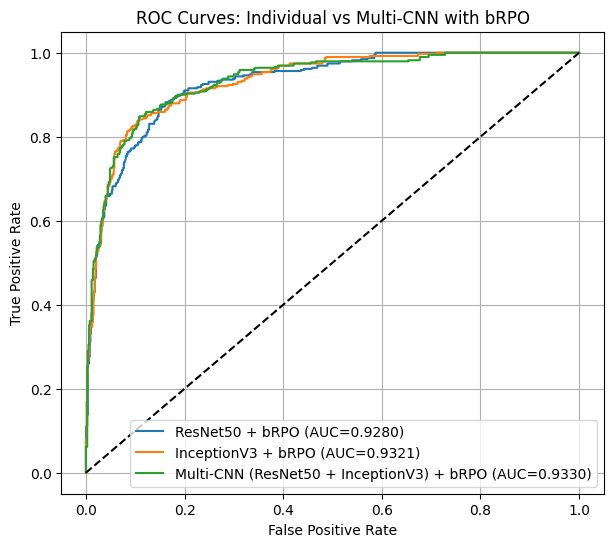

In [15]:
# ============================================================
# Utility: Evaluate any feature set with bRPO + SVM
# ============================================================

def evaluate_with_bRPO(Ftr, Fte, ytr, yte, model_name):
    # --- bRPO Feature Selection ---
    mask = bRPO(Ftr, ytr)
    assert mask.sum() > 0, "bRPO selected zero features!"

    Xtr_sel = Ftr[:, mask == 1]
    Xte_sel = Fte[:, mask == 1]

    print(f"\n{model_name}")
    print("Selected features:", Xtr_sel.shape[1])

    # --- Classification ---
    clf = SVC(kernel="rbf", probability=True)
    clf.fit(Xtr_sel, ytr)

    preds = clf.predict(Xte_sel)
    probs = clf.predict_proba(Xte_sel)

    acc = accuracy_score(yte, preds)
    cm = confusion_matrix(yte, preds)

    sensitivity = np.mean(np.diag(cm) / cm.sum(axis=1))
    specificity = np.mean(
        (cm.sum() - cm.sum(axis=0) - cm.sum(axis=1) + np.diag(cm)) /
        (cm.sum() - cm.sum(axis=1))
    )

    # --- ROC & AUC ---
    y_bin = label_binarize(yte, classes=np.unique(yte))
    fpr, tpr, _ = roc_curve(y_bin.ravel(), probs.ravel())
    auc_val = auc(fpr, tpr)

    return {
        "Model": model_name,
        "Accuracy": acc,
        "Sensitivity": sensitivity,
        "Specificity": specificity,
        "AUC": auc_val,
        "FPR": fpr,
        "TPR": tpr
    }


# ============================================================
# STEP 6–8: Evaluate All Configurations
# ============================================================

results = []

# ---- ResNet50 + bRPO ----
results.append(
    evaluate_with_bRPO(
        F_res_tr, F_res_te, ytr, yte,
        "ResNet50 + bRPO"
    )
)

# ---- InceptionV3 + bRPO ----
results.append(
    evaluate_with_bRPO(
        F_inc_tr, F_inc_te, ytr, yte,
        "InceptionV3 + bRPO"
    )
)

# ---- Multi-CNN (ResNet50 + InceptionV3) + bRPO ----
F_multi_tr = np.concatenate([F_res_tr, F_inc_tr], axis=1)
F_multi_te = np.concatenate([F_res_te, F_inc_te], axis=1)

results.append(
    evaluate_with_bRPO(
        F_multi_tr, F_multi_te, ytr, yte,
        "Multi-CNN (ResNet50 + InceptionV3) + bRPO"
    )
)

# ============================================================
# Performance Table
# ============================================================

df_results = pd.DataFrame(results)[
    ["Model", "Accuracy", "Sensitivity", "Specificity", "AUC"]
]

display(df_results.round(4))


# ============================================================
# ROC Curve Comparison
# ============================================================

plt.figure(figsize=(7,6))

for r in results:
    plt.plot(
        r["FPR"], r["TPR"],
        label=f'{r["Model"]} (AUC={r["AUC"]:.4f})'
    )

plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves: Individual vs Multi-CNN with bRPO")
plt.legend()
plt.grid()
plt.show()
